### WLLS_II_estimator.ipynb
- Siep Dokter
- Emil Jousimaa
- Oleksandr Sosovskyy
- Mario Gabriele Carofano

> This file contains the implementation of the ML estimator as requested in the 5th task, used for estimate the Target Coordinates starting from the RSS information coming from the anchors.

> In addition, at the end of file, there are also plots showing the actual position of the target and the anchors, and the estimated position of the target obtained from the execution of the ML estimator.

In [1]:
# IMPORTS
import import_ipynb
import constants
import auxfunc
import pandas as pd
import numpy as np
import pprint
import math
from itertools import product
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

importing Jupyter notebook from constants.ipynb
importing Jupyter notebook from auxfunc.ipynb


In [2]:
def calculate_ML_output1(powers, anchors_coordinates):
    """
    Estimate the target coordinates using a grid search approach.

    Parameters:
    powers (numpy.ndarray): Vector of received powers.
    anchors_coordinates (list): List of anchor coordinates.

    Returns:
    target_coordinates (numpy.ndarray): Estimated target coordinates.
    """
    def objective_function(coordinates):
        # print("--------")
        # print("np.array(coordinates): ", np.array(coordinates))
        # print("np.array(anchors_coordinates) ", np.array(anchors_coordinates))
        lambda_values = np.array([
            constants.REFERENCE_POWER - (10 * constants.PATH_LOSS_EXPONENT * np.log10(np.linalg.norm(np.array(anchor) - np.array(coordinates))))
            for anchor in anchors_coordinates
        ])
        
        # print("lambda_values: ", lambda_values)
        # print("powers: ", powers)
        
        final_sum = np.linalg.norm(powers - lambda_values)
        # print("final_sum", final_sum)
        
        final_sum = final_sum
        
        objective_result = final_sum / pow(constants.STANDARD_DEVIATION, 2)
        return objective_result
    
    grid_size = 100

    # Generate a grid of coordinates to try
    grid_values = np.linspace(-15, 15, grid_size)
    grid_coordinates = [(x, y) for x in grid_values for y in grid_values]

    # Evaluate the objective function for each point on the grid
    results = [objective_function(coords) for coords in grid_coordinates]

    # Find the coordinates with the minimum objective value
    min_index = np.argmin(results)
    target_coordinates = grid_coordinates[min_index]

    return target_coordinates

In [3]:
def calculate_ML_output(powers, anchors_coordinates):
    """
    Estimate the target coordinates using the minimize function with the Nelder-Mead method.

    Parameters:
    powers (numpy.ndarray): Vector of received powers.
    anchors_coordinates (list): List of anchor coordinates.

    Returns:
    target_coordinates (numpy.ndarray): Estimated target coordinates.
    """
    def objective_function(coordinates):
        lambda_values = np.array([
            constants.REFERENCE_POWER - (10 * constants.PATH_LOSS_EXPONENT * np.log10(np.linalg.norm(np.array(anchor) - np.array(coordinates))))
            for anchor in anchors_coordinates
        ])
        
        final_sum = np.linalg.norm(powers - lambda_values)
        objective_result = final_sum / pow(constants.STANDARD_DEVIATION, 2)
        return objective_result
    
    # Initial guess for target coordinates
    initial_guess = [1,2]  # Assuming 2D coordinates

    # Use the minimize function with Nelder-Mead method
    result = minimize(objective_function, initial_guess, method='Nelder-Mead')

    # Extract the optimized coordinates
    target_coordinates = result.x
    
    print("target_coordinates: ", target_coordinates)

    return target_coordinates

In [4]:
def apply_ML_estimator(scenario_name):
	'''
	Applies the ML.X
	It is used for estimate the target's position from the anchors' position.

	Parameters:
	scenario_name (str): The name of the scenario to be examined.

	Returns:
	data (dict):
	It is a dictionary containing all the salient information retrieved
	from the reading of the dataset (Actual) and from the application of the WLLS_II estimator (Estimated),
	for all types of devices (Arduino, RPI) and for all technology (WiFi, BLT, Hybrid).
	'''
	
	dataset = auxfunc.define_dataset(scenario_name)

	for type in dataset[scenario_name]:

		dict = dataset[scenario_name][type]
		type_path = constants.DATASET_DIRECTORY + scenario_name + "/" + type + "/"

		for tech in dict:
			dataframes = []
			if tech != constants.HYBRID_TECHNOLOGY:
				for a in dict[tech]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + tech + "/" + a
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			else:
				# Concatenates the blt and wifi estimations
				for b in dict[constants.BLT_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.BLT_TECHNOLOGY + "/" + b
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))

				for w in dict[constants.WIFI_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.WIFI_TECHNOLOGY + "/" + w
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			
			dict[tech]["Actual"]["Dataframes"] = dataframes

		for tech in dict:
			dataframes = dict[tech]["Actual"]["Dataframes"]
			length = auxfunc.calculate_smallest_dataset(dataframes)
			burst_quantity = auxfunc.calculate_burst_quantity(length)
			n_anchors = len(dict[tech]["Actual"]["Anchors' Name"])

			# print(type, tech, length, burst_quantity, n_anchors, len(dataframes))

			dict[tech]["Actual"]["Distance Target - Anchor"] = []
			dict[tech]["Actual"]["Anchor Coordinates"] = []
			for a in range(n_anchors):
				dict[tech]["Actual"]["Distance Target - Anchor"].append(dataframes[a]["Distance Target - Anchor [m]"][0])
				dict[tech]["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes[a]["Target Coordinates [m]"][0].split(", ")]
				dict[tech]["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes[a]["Relative Coordinates [m]"][0].split(", ")])

			for c in range(burst_quantity):
				dict[tech]["Estimated"][c] = {}
				dict[tech]["Estimated"][c]["Average RSS"] = []
				dict[tech]["Estimated"][c]["Distance Target - Anchor"] = []
				
				for a in range(n_anchors):
					average_RSS = auxfunc.calculate_average_RSS(dataframes[a]["Rx Power [dBm]"].to_list(), c, length)
					estimated_distance = auxfunc.calculate_target_anchor_estimation(average_RSS)
					dict[tech]["Estimated"][c]["Average RSS"].append(average_RSS)
					dict[tech]["Estimated"][c]["Distance Target - Anchor"].append(estimated_distance)
     
				dict[tech]["Estimated"][c]["Target Coordinates"] = calculate_ML_output(dict[tech]["Estimated"][c]["Average RSS"], dict[tech]["Actual"]["Anchor Coordinates"])

				print("ML target_coordinates: ", dict[tech]["Estimated"][c]["Target Coordinates"], scenario_name)
			
			dataset[scenario_name][type][tech] = dict[tech]

	return dataset
	
# https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array

In [5]:
data = {}
data.update(apply_ML_estimator("Scenario A"))
data.update(apply_ML_estimator("Scenario B"))
data.update(apply_ML_estimator("Scenario C"))

# np.set_printoptions(suppress=True)
# pprint.pprint(data)
# for configuration in data["Scenario A"]["RPI"]["RSS_BLT_Dataset"]["Estimated"].values():
#     pprint.pprint(configuration["Target Coordinates"])

target_coordinates:  [-6.31166101 -3.42032549]
ML target_coordinates:  [-6.31166101 -3.42032549] Scenario A
target_coordinates:  [-6.36044432 -3.19052267]
ML target_coordinates:  [-6.36044432 -3.19052267] Scenario A
target_coordinates:  [-5.95563489 -4.01215754]
ML target_coordinates:  [-5.95563489 -4.01215754] Scenario A
target_coordinates:  [-5.99757246 -3.40829935]
ML target_coordinates:  [-5.99757246 -3.40829935] Scenario A
target_coordinates:  [-6.17489162 -3.49997582]
ML target_coordinates:  [-6.17489162 -3.49997582] Scenario A
target_coordinates:  [-5.86343415 -3.59450371]
ML target_coordinates:  [-5.86343415 -3.59450371] Scenario A
target_coordinates:  [-5.50368528 -4.21885054]
ML target_coordinates:  [-5.50368528 -4.21885054] Scenario A
target_coordinates:  [-6.31631777 -3.65686231]
ML target_coordinates:  [-6.31631777 -3.65686231] Scenario A
target_coordinates:  [-6.1279343  -3.92624276]
ML target_coordinates:  [-6.1279343  -3.92624276] Scenario A
target_coordinates:  [-5.379

In [6]:
for scenario in data:
    print("RMSE per", scenario)
    for type in data[scenario]:
        for tech in data[scenario][type]:
            print(type + "_" + tech + ":", auxfunc.calculate_rmse(data[scenario][type][tech]), "m")
    print()

RMSE per Scenario A
RPI_RSS_BLT_Dataset: 7.117 m
RPI_RSS_WiFi_Dataset: 6.632 m
RPI_RSS_Hybrid_Dataset: 6.377 m
Arduino_RSS_WiFi_Dataset_5dbm: 2.112 m
Arduino_RSS_WiFi_Dataset_0dbm: 2.755 m
Arduino_RSS_WiFi_Dataset_15dbm: 3.879 m
Arduino_RSS_WiFi_Dataset_10dbm: 3.321 m
Arduino_RSS_WiFi_Dataset_20dbm: 5.335 m

RMSE per Scenario B
RPI_RSS_BLT_Dataset: 14.347 m
RPI_RSS_WiFi_Dataset: 15.13 m
RPI_RSS_Hybrid_Dataset: 14.655 m

RMSE per Scenario C
RPI_RSS_BLT_Dataset: 4.84 m
RPI_RSS_WiFi_Dataset: 5.871 m
RPI_RSS_Hybrid_Dataset: 2.639 m



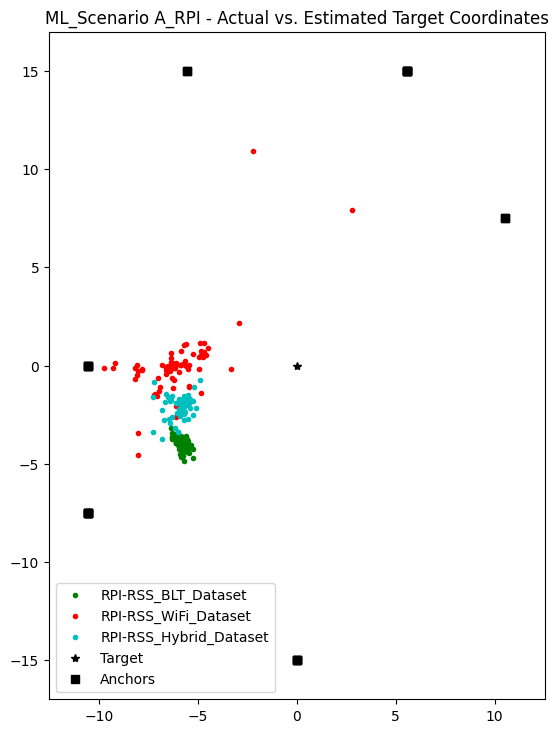

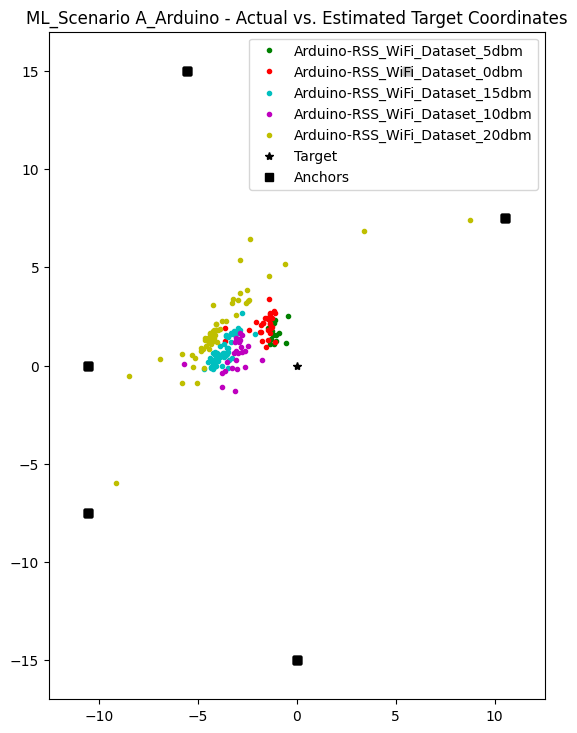

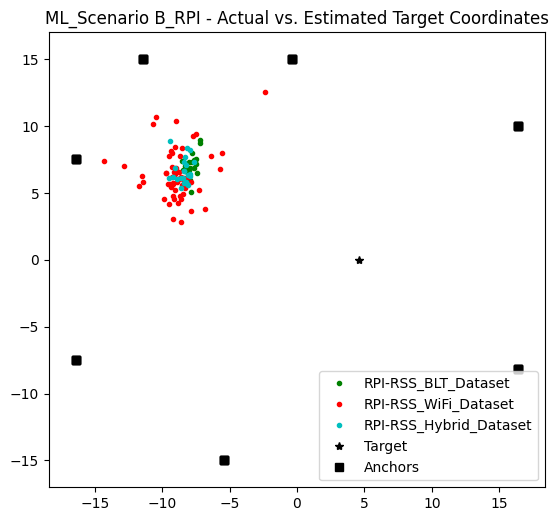

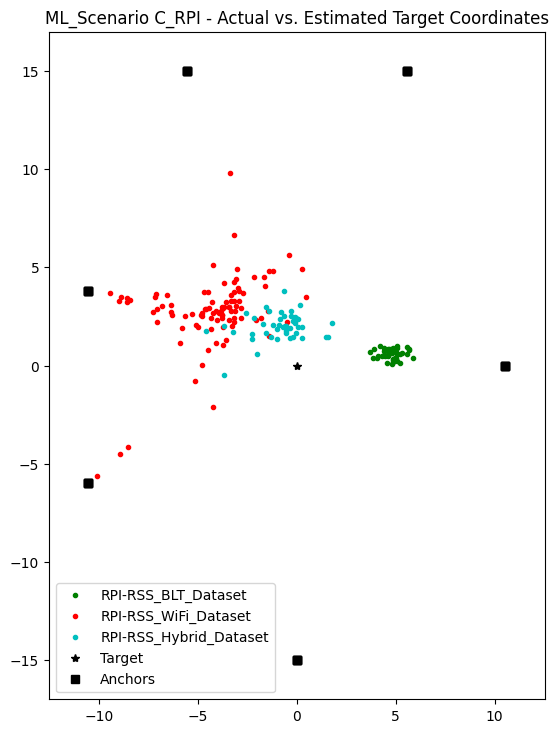

In [7]:
auxfunc.plot_data("ML", data)